In [4]:
# If you have ROS in your system please uncomment the two lines below
# import sys
# sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

import cv2
import numpy as np
from pathlib import Path

from hfnet.settings import EXPER_PATH
from notebooks.utils import plot_images, plot_matches, add_frame

import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
tf.contrib.resampler  # import C++ op

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load query (night) and database (day) images

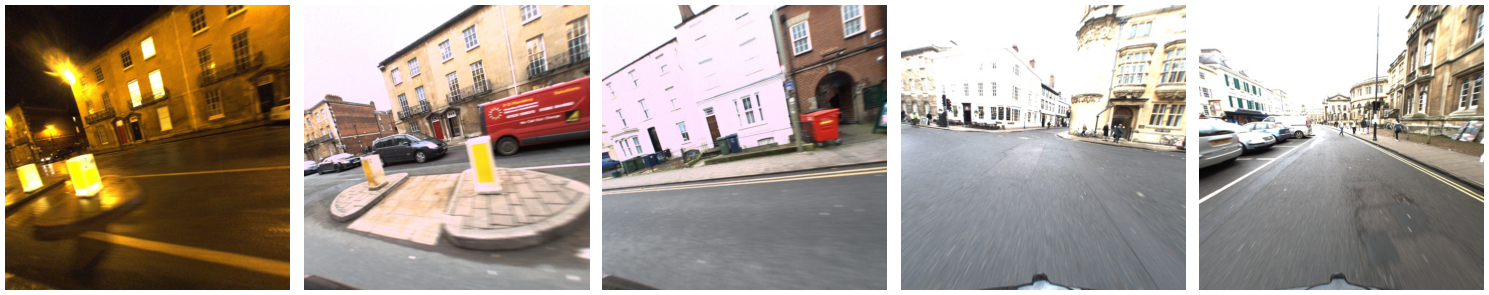

In [5]:
query_idx = 2  # also try with 2 and 3
read_image = lambda n: cv2.imread('doc/demo/' + n)[:, :, ::-1]
image_query = read_image(f'query{query_idx}.jpg')
images_db = [read_image(f'db{i}.jpg') for i in range(1, 5)]

plot_images([image_query] + images_db, dpi=50)

# Create HF-Net model for inference

In [6]:
class HFNet:
    def __init__(self, model_path, outputs):
        self.session = tf.Session()
        self.image_ph = tf.placeholder(tf.float32, shape=(None, None, 3))

        net_input = tf.image.rgb_to_grayscale(self.image_ph[None])
        tf.saved_model.loader.load(
            self.session, [tag_constants.SERVING], str(model_path),
            clear_devices=True,
            input_map={'image:0': net_input})

        graph = tf.get_default_graph()
        self.outputs = {n: graph.get_tensor_by_name(n+':0')[0] for n in outputs}
        self.nms_radius_op = graph.get_tensor_by_name('pred/simple_nms/radius:0')
        self.num_keypoints_op = graph.get_tensor_by_name('pred/top_k_keypoints/k:0')
        
    def inference(self, image, nms_radius=4, num_keypoints=1000):
        inputs = {
            self.image_ph: image[..., ::-1].astype(np.float),
            self.nms_radius_op: nms_radius,
            self.num_keypoints_op: num_keypoints,
        }
        return self.session.run(self.outputs, feed_dict=inputs)

model_path = Path(EXPER_PATH, 'saved_models/hfnet')
outputs = ['global_descriptor', 'keypoints', 'local_descriptors']
hfnet = HFNet(model_path, outputs)

[08/31/2022 15:57:02 INFO] Restoring parameters from /home/server/hfnet/log/saved_models/hfnet/variables/variables


# Compute global descriptors and local features for query and database

In [7]:
db = [hfnet.inference(i) for i in images_db]
global_index = np.stack([d['global_descriptor'] for d in db])
query = hfnet.inference(image_query)

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,?,3]
	 [[node Placeholder (defined at <ipython-input-3-909a7f2c901b>:4)  = Placeholder[dtype=DT_FLOAT, shape=[?,?,3], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[{{node rgb_to_grayscale/Tensordot/axes/_557}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_12_rgb_to_grayscale/Tensordot/axes", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Placeholder', defined at:
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/asyncio/base_events.py", line 442, in run_forever
    self._run_once()
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/asyncio/base_events.py", line 1462, in _run_once
    handle._run()
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/tornado/ioloop.py", line 688, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/tornado/gen.py", line 814, in inner
    self.ctx_run(self.run)
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/tornado/gen.py", line 162, in _fake_ctx_run
    return f(*args, **kw)
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/tornado/gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/tornado/gen.py", line 162, in _fake_ctx_run
    return f(*args, **kw)
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/tornado/gen.py", line 162, in _fake_ctx_run
    return f(*args, **kw)
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/tornado/gen.py", line 162, in _fake_ctx_run
    return f(*args, **kw)
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 302, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2867, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2895, in _run_cell
    return runner(coro)
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3072, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3263, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-909a7f2c901b>", line 27, in <module>
    hfnet = HFNet(model_path, outputs)
  File "<ipython-input-3-909a7f2c901b>", line 4, in __init__
    self.image_ph = tf.placeholder(tf.float32, shape=(None, None, 3))
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1747, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 5206, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,?,3]
	 [[node Placeholder (defined at <ipython-input-3-909a7f2c901b>:4)  = Placeholder[dtype=DT_FLOAT, shape=[?,?,3], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[{{node rgb_to_grayscale/Tensordot/axes/_557}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_12_rgb_to_grayscale/Tensordot/axes", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


# Perform a global search in the database

In [8]:
def compute_distance(desc1, desc2):
    # For normalized descriptors, computing the distance is a simple matrix multiplication.
    return 2 * (1 - desc1 @ desc2.T)

In [9]:
nearest = np.argmin(compute_distance(query['global_descriptor'], global_index))

disp_db = [add_frame(im, (0, 255, 0)) if i == nearest else im
           for i, im in enumerate(images_db)]
plot_images([image_query] + disp_db, dpi=50)

NameError: name 'query' is not defined

# Perform local matching with the retrieved image

In [8]:
def match_with_ratio_test(desc1, desc2, thresh):
    dist = compute_distance(desc1, desc2)
    nearest = np.argpartition(dist, 2, axis=-1)[:, :2]
    dist_nearest = np.take_along_axis(dist, nearest, axis=-1)
    valid_mask = dist_nearest[:, 0] <= (thresh**2)*dist_nearest[:, 1]
    matches = np.stack([np.where(valid_mask)[0], nearest[valid_mask][:, 0]], 1)
    return matches

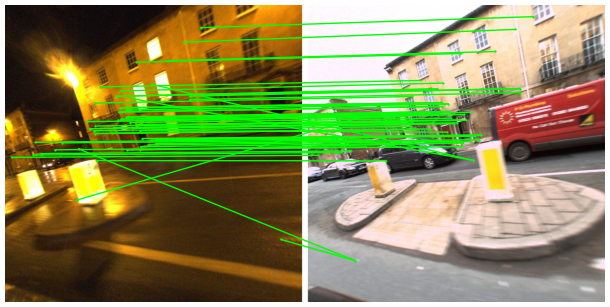

In [13]:
matches = match_with_ratio_test(query['local_descriptors'],
                                db[nearest]['local_descriptors'], 0.8)

plot_matches(image_query, query['keypoints'],
             images_db[nearest], db[nearest]['keypoints'],
             matches, color=(0, 1, 0), dpi=50)